In [6]:
import numpy as np
from numpy import linalg

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import cvxopt
import cvxopt.solvers

### Tự xây dựng SVM

In [ ]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, gamma = 1, r = 1, d=3):
    return (r + gamma*np.dot(x, y)) ** d

def gaussian_kernel(x, y, sigma=5.0):
    # gamma = 1.0/(2 * (sigma ** 2)) 
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

  

#X1, Y1, X2, Y2 = gen_circle_data()
# visualizing data
#plt.scatter(X1[:, 0], X1[:, 1], c = 'red', marker = 'o')
#plt.scatter(X2[:, 0], X2[:, 1], c = 'blue', marker = '^')
#plt.show()

In [8]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))



     pcost       dcost       gap    pres   dres
 0: -5.6321e+00 -7.8638e+00  4e+02  2e+01  1e+00
 1: -1.3186e+00 -3.1535e-01  2e+01  1e+00  6e-02
 2:  2.4387e-03 -2.2291e-01  3e-01  4e-03  3e-04
 3: -5.4871e-02 -9.3212e-02  4e-02  2e-05  1e-06
 4: -6.9089e-02 -9.3274e-02  2e-02  1e-05  7e-07
 5: -8.4292e-02 -8.7835e-02  4e-03  1e-06  7e-08
 6: -8.6767e-02 -8.6923e-02  2e-04  4e-08  2e-09
 7: -8.6884e-02 -8.6887e-02  3e-06  5e-10  3e-11
 8: -8.6886e-02 -8.6886e-02  3e-08  5e-12  3e-13
Optimal solution found.
9 support vectors out of 180 points
20 out of 20 predictions correct


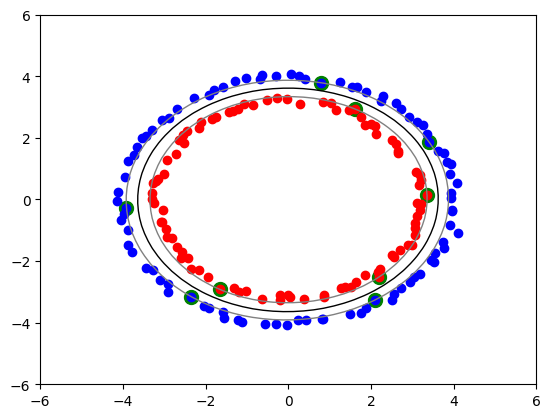

Accuracy: 1.0
Confusion Matrix: [[10  0]
 [ 0 10]]


In [10]:
if __name__ == "__main__":
    import pylab as pl

    def gen_lin_separable_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[0.8, 0.6], [0.6, 0.8]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_non_lin_separable_data():
        mean1 = [-1, 2]
        mean2 = [1, -1]
        mean3 = [4, -4]
        mean4 = [-4, 4]
        cov = [[1.0,0.8], [0.8, 1.0]]
        X1 = np.random.multivariate_normal(mean1, cov, 50)
        X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 50)
        X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def gen_circle_data():
        # Generate dataset and targets
        X, Y = make_circles(n_samples = 200, noise = 0.02)
        X1 = 4.0*X[Y==1, :]
        X2 = 4.0*X[Y==0, :]
        y1 = np.ones(len(X1))
        y2 = np.ones(len(X2)) * -1

        return X1, y1, X2, y2     
    
    def gen_lin_separable_overlap_data():
        # generate training data in the 2-d case
        mean1 = np.array([0, 2])
        mean2 = np.array([2, 0])
        cov = np.array([[1.5, 1.0], [1.0, 1.5]])
        X1 = np.random.multivariate_normal(mean1, cov, 100)
        y1 = np.ones(len(X1))
        X2 = np.random.multivariate_normal(mean2, cov, 100)
        y2 = np.ones(len(X2)) * -1
        return X1, y1, X2, y2

    def split_train(X1, y1, X2, y2):
        X1_train = X1[:90]
        y1_train = y1[:90]
        X2_train = X2[:90]
        y2_train = y2[:90]
        X_train = np.vstack((X1_train, X2_train))
        y_train = np.hstack((y1_train, y2_train))
        return X_train, y_train

    def split_test(X1, y1, X2, y2):
        X1_test = X1[90:]
        y1_test = y1[90:]
        X2_test = X2[90:]
        y2_test = y2[90:]
        X_test = np.vstack((X1_test, X2_test))
        y_test = np.hstack((y1_test, y2_test))
        return X_test, y_test

    def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line
            # w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

    def plot_contour(X1_train, X2_train, clf):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = clf.project(X).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

    def test_linear():
        X1, y1, X2, y2 = gen_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM()
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)

    def test_non_linear():
        X1, y1, X2, y2 = gen_circle_data()
        #X1, y1, X2, y2 = gen_non_lin_separable_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(polynomial_kernel)
        #clf = SVM(gaussian_kernel)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)
        
        print("Accuracy:", accuracy_score(y_test, y_predict))
        print("Confusion Matrix:", confusion_matrix(y_test, y_predict))

    def test_soft():
        X1, y1, X2, y2 = gen_lin_separable_overlap_data()
        X_train, y_train = split_train(X1, y1, X2, y2)
        X_test, y_test = split_test(X1, y1, X2, y2)

        clf = SVM(C=1000.1)
        clf.fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        correct = np.sum(y_predict == y_test)
        print("%d out of %d predictions correct" % (correct, len(y_predict)))

        plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

        
    #test_linear()
    test_non_linear()
    #test_soft()

### Sử dụng thư viện sklearn

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import warnings
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
# Generate dataset and targets
X, Y = make_circles(n_samples = 200, noise = 0.02)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=1)

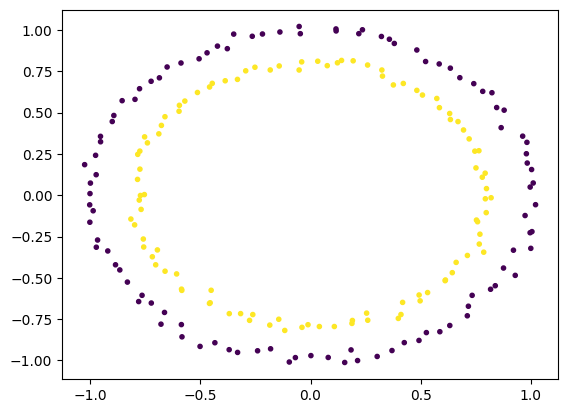

In [27]:
# visualizing data
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.')
plt.show()

Accuracy with kernel 'linear': 0.43333333333333335
Confusion Matrix with kernel 'linear': [[ 0 34]
 [ 0 26]]
Accuracy with kernel 'sigmoid': 0.55
Confusion Matrix with kernel 'sigmoid': [[15 19]
 [ 8 18]]
Accuracy with kernel 'poly': 1.0
Confusion Matrix with kernel 'poly': [[34  0]
 [ 0 26]]
Accuracy with kernel 'rbf': 1.0
Confusion Matrix with kernel 'rbf': [[34  0]
 [ 0 26]]


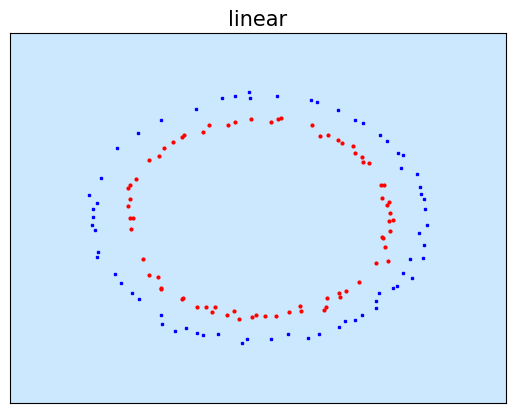

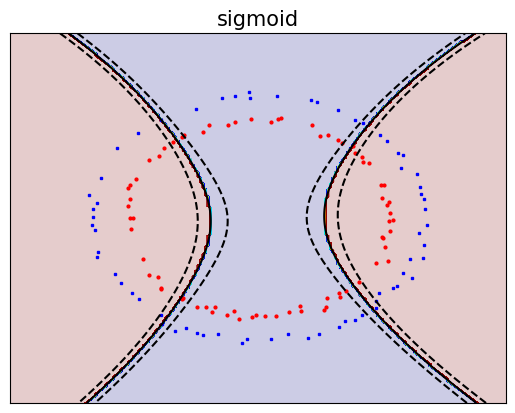

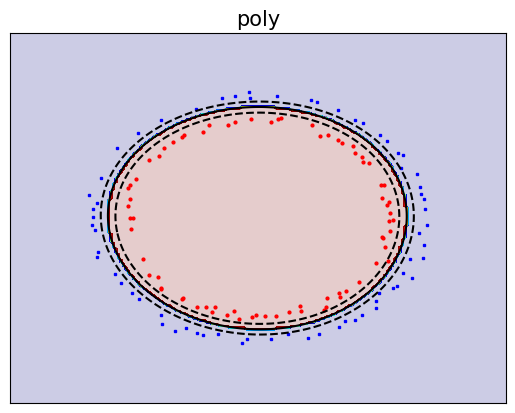

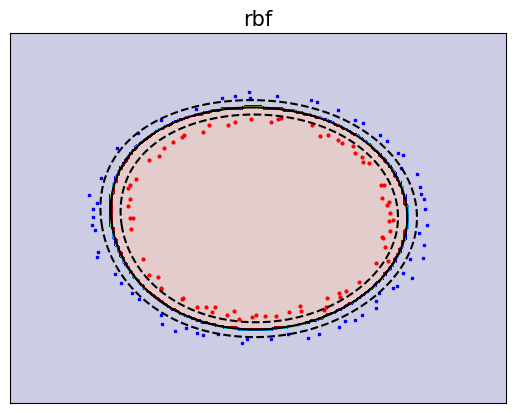

In [31]:
fignum = 1

# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    print(f"Accuracy with kernel '{kernel}':", accuracy_score(y_test, y_pred))
    print(f"Confusion Matrix with kernel '{kernel}':", confusion_matrix(y_test, y_pred))
    
    with PdfPages(kernel + '3.pdf') as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()
        
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='None')
        
        plt.plot(X_train[y_train==0, 0], X_train[y_train==0, 1], 'bs', markersize = 2)
        plt.plot(X_train[y_train==1, 0], X_train[y_train==1, 1], 'ro', markersize = 2)
        
        plt.axis('tight') 
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5
        
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
        
        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        # pdf.savefig()
plt.show()